# 10. Pruning, Distillation, and Speculative Decoding

In this tutorial we explore three widely-used techniques for compressing and accelerating neural networks:

1. **Magnitude pruning**, which removes the parameters that contribute the least to a model's predictions.
2. **Knowledge distillation**, which transfers knowledge from a larger teacher network into a smaller student.
3. **Speculative decoding**, which speeds up auto-regressive text generation by combining a lightweight draft model with a larger target model.

We start with a toy classification problem so that we can reason about the effects of pruning and distillation visually. We then move to a causal language modeling setup inspired by the `Qwen3` family of models where we leverage Hugging Face's `DistillationTrainer` API and finish with speculative decoding.


## 1. Setup

We rely on PyTorch for modeling, `matplotlib` for visualization, and a few helper utilities for tracking progress. The code below also defines helper functions for reproducibility and device management.

In [1]:
import math
import random
import time
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


## 2. A Toy Classification Task

To make the ideas concrete we create a two-dimensional synthetic dataset with two classes that *are* linearly separable. That allows us to train a single-layer linear classifier and visualize both the data and the resulting decision boundary easily.

We draw points from two Gaussians and assign labels $y \in \{0, 1\}$. The model learns a simple linear decision boundary $f(\mathbf{x}) = \mathbf{w}^	op \mathbf{x} + b$. The logits are converted into probabilities via the sigmoid function and we optimize the binary cross-entropy loss:

$$
\ell(\mathbf{w}, b) = - \frac{1}{N} \sum_{i=1}^N \Big[y_i \log \sigma(f(\mathbf{x}_i)) + (1 - y_i) \log (1 - \sigma(f(\mathbf{x}_i)))\Big].
$$

In [2]:
def make_linear_dataset(n_per_class: int = 200, spread: float = 0.6):
    mean_pos = torch.tensor([1.5, 1.5])
    mean_neg = torch.tensor([-1.5, -1.5])
    cov = torch.eye(2) * spread
    pos = torch.distributions.MultivariateNormal(mean_pos, cov).sample((n_per_class,))
    neg = torch.distributions.MultivariateNormal(mean_neg, cov).sample((n_per_class,))
    X = torch.cat([pos, neg], dim=0)
    y = torch.cat([torch.ones(n_per_class), torch.zeros(n_per_class)], dim=0)
    perm = torch.randperm(len(X))
    return X[perm], y.long()[perm]

X, y = make_linear_dataset()
print(X.shape, y.shape)

torch.Size([400, 2]) torch.Size([400])


Let's visualize the data. 

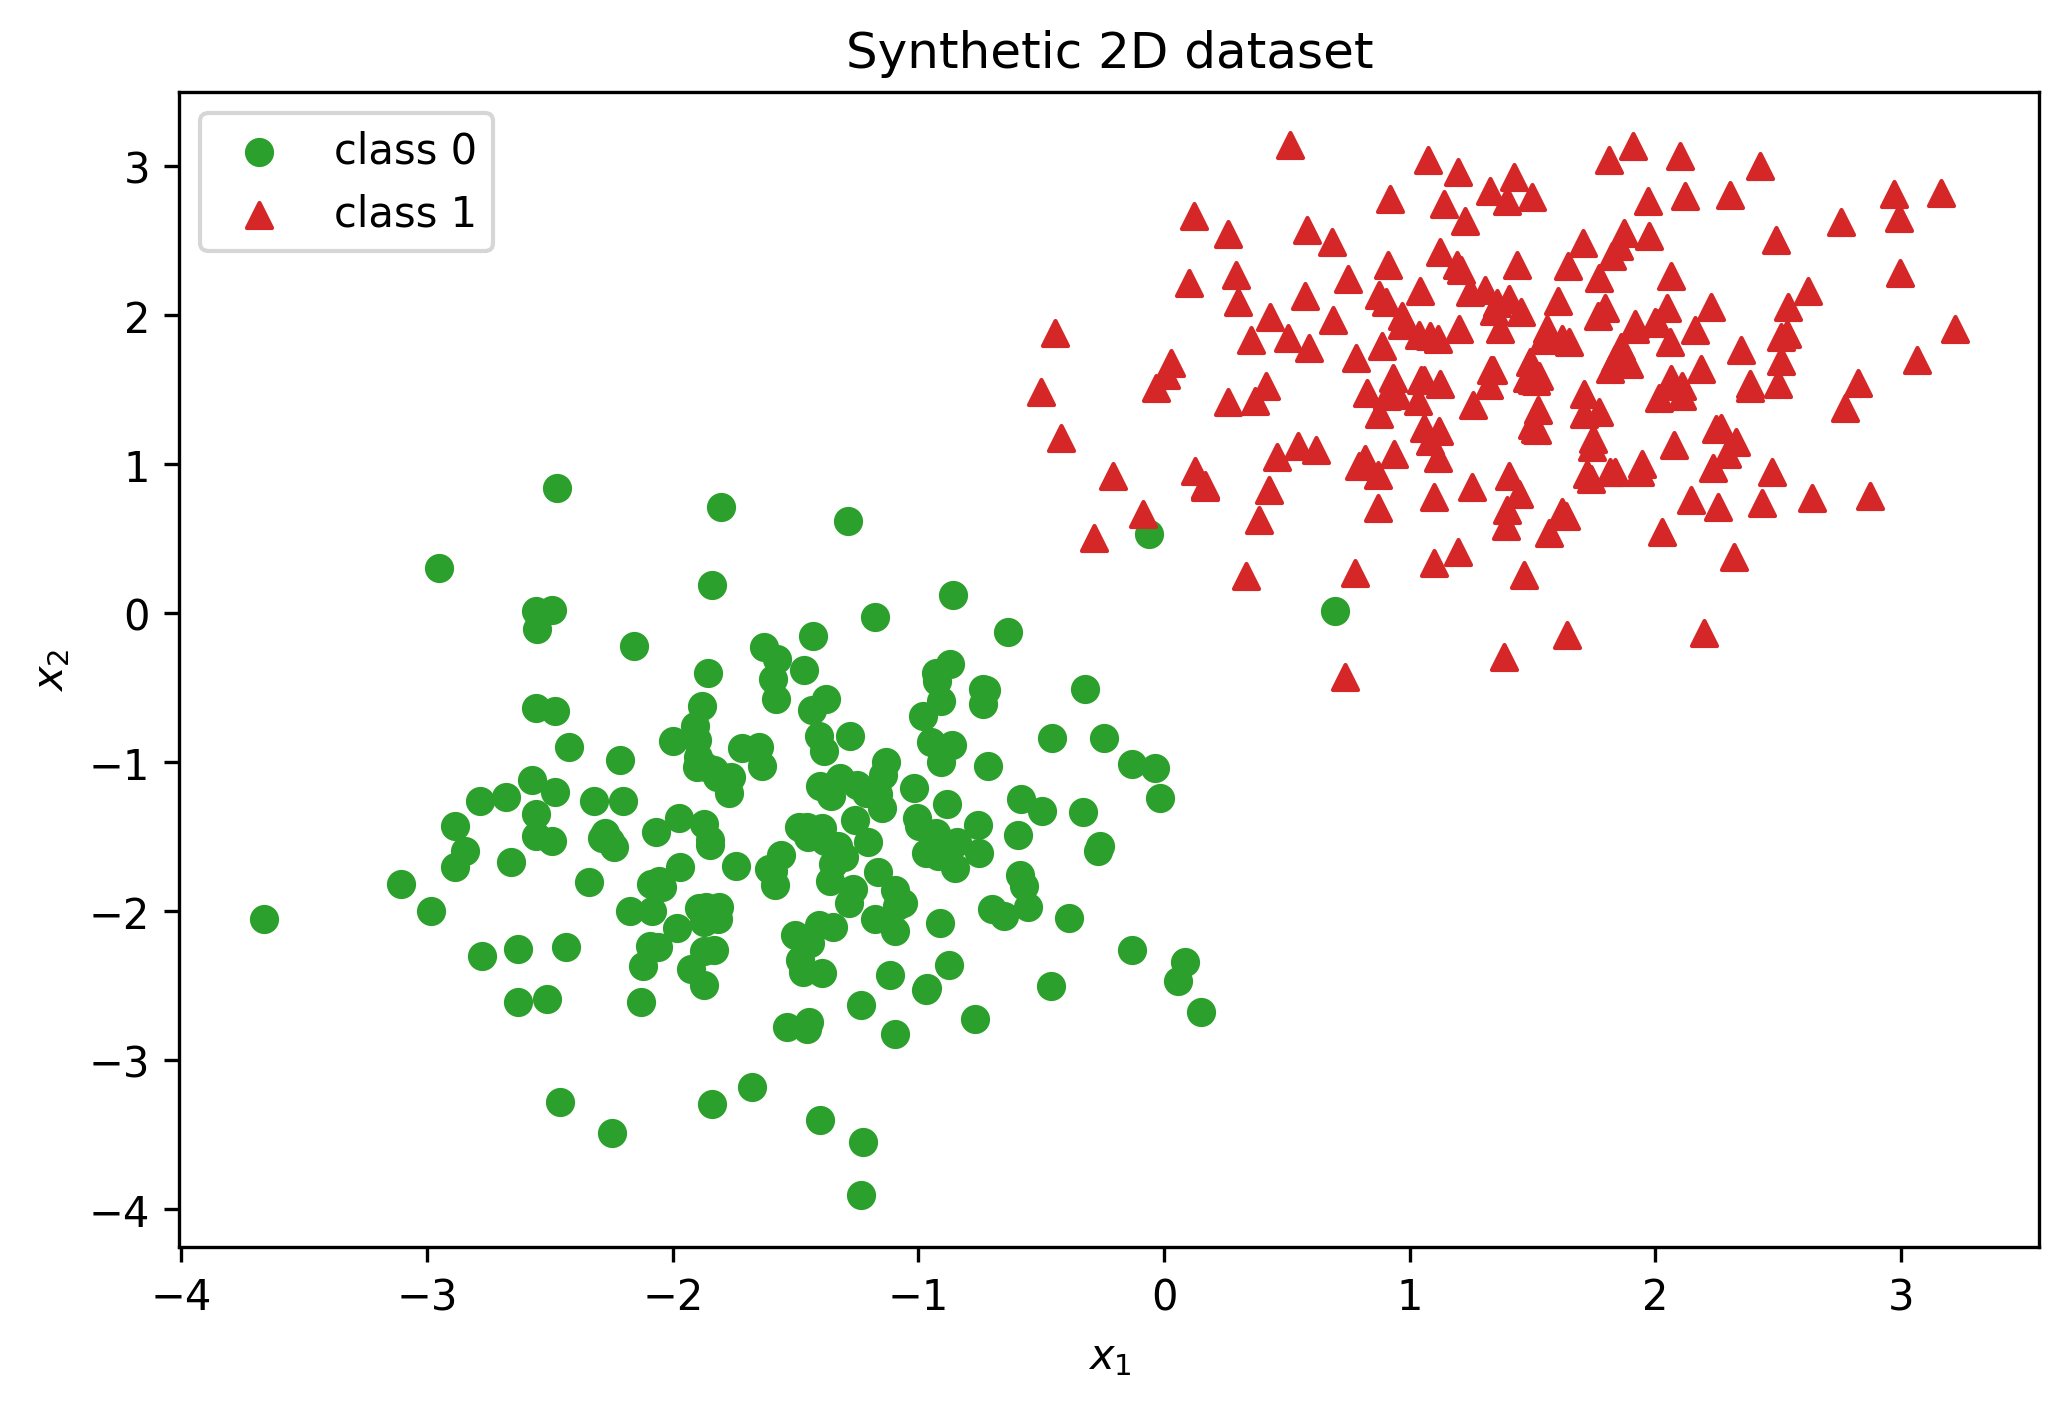

In [13]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
for label, marker, color in [(0, 'o', '#2ca02c'), (1, '^', '#d62728')]:
    mask = y == label
    ax.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, label=f'class {label}')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Synthetic 2D dataset')
ax.legend()
plt.show()

### 2.1 Training a Single-Layer Classifier

Our model is a single dense layer followed by a sigmoid. For convenience we package training and evaluation loops that report the loss and accuracy on train/test splits.

In [21]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.linear = nn.Linear(in_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x).squeeze(-1)


def train_classifier(model: nn.Module, data: Tuple[torch.Tensor, torch.Tensor], epochs: int = 200, lr: float = 0.1):
    X, y = data
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    history = []
    for epoch in range(epochs):
        model.train()
        logits = model(X)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            preds = (logits.sigmoid() > 0.5).long()
            acc = (preds == y).float().mean().item()
        history.append((loss.item(), acc))
    return history


def plot_history(history, title: str):
    losses, accs = zip(*history)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
    ax[0].plot(losses)
    ax[0].set_title(f'{title} loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[1].plot(accs)
    ax[1].set_title(f'{title} accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    plt.show()

Let's see the training curves.

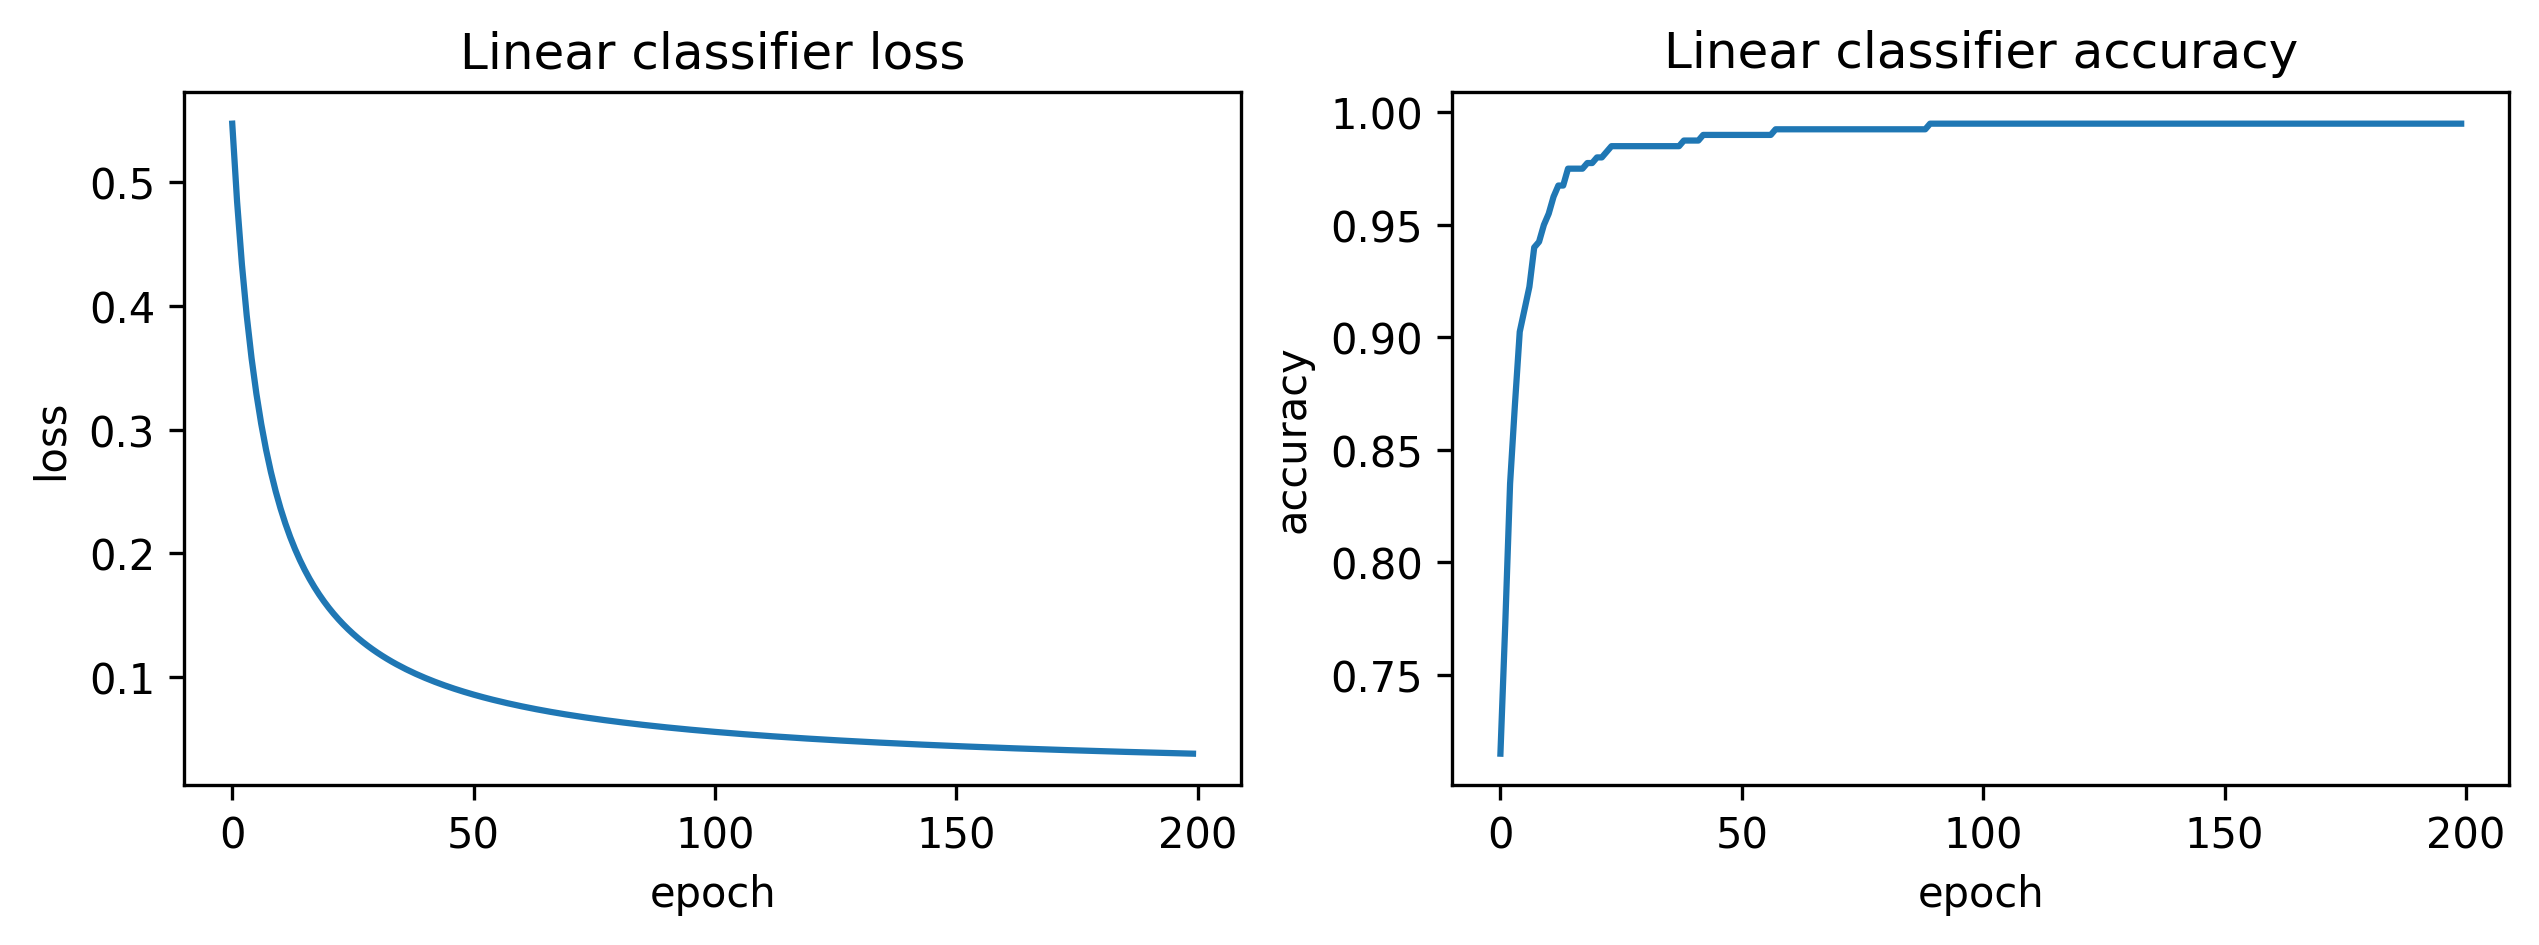

In [30]:
model = LinearClassifier(in_dim=2)
history = train_classifier(model, (X, y))
plot_history(history, 'Linear classifier')

### 2.2 Visualizing the Decision Boundary

The decision boundary is the set of points where the predicted probability equals 0.5, i.e. $f(\mathbf{x}) = 0$. We evaluate the model on a dense grid and color the prediction regions to see how the linear separator aligns with the data.

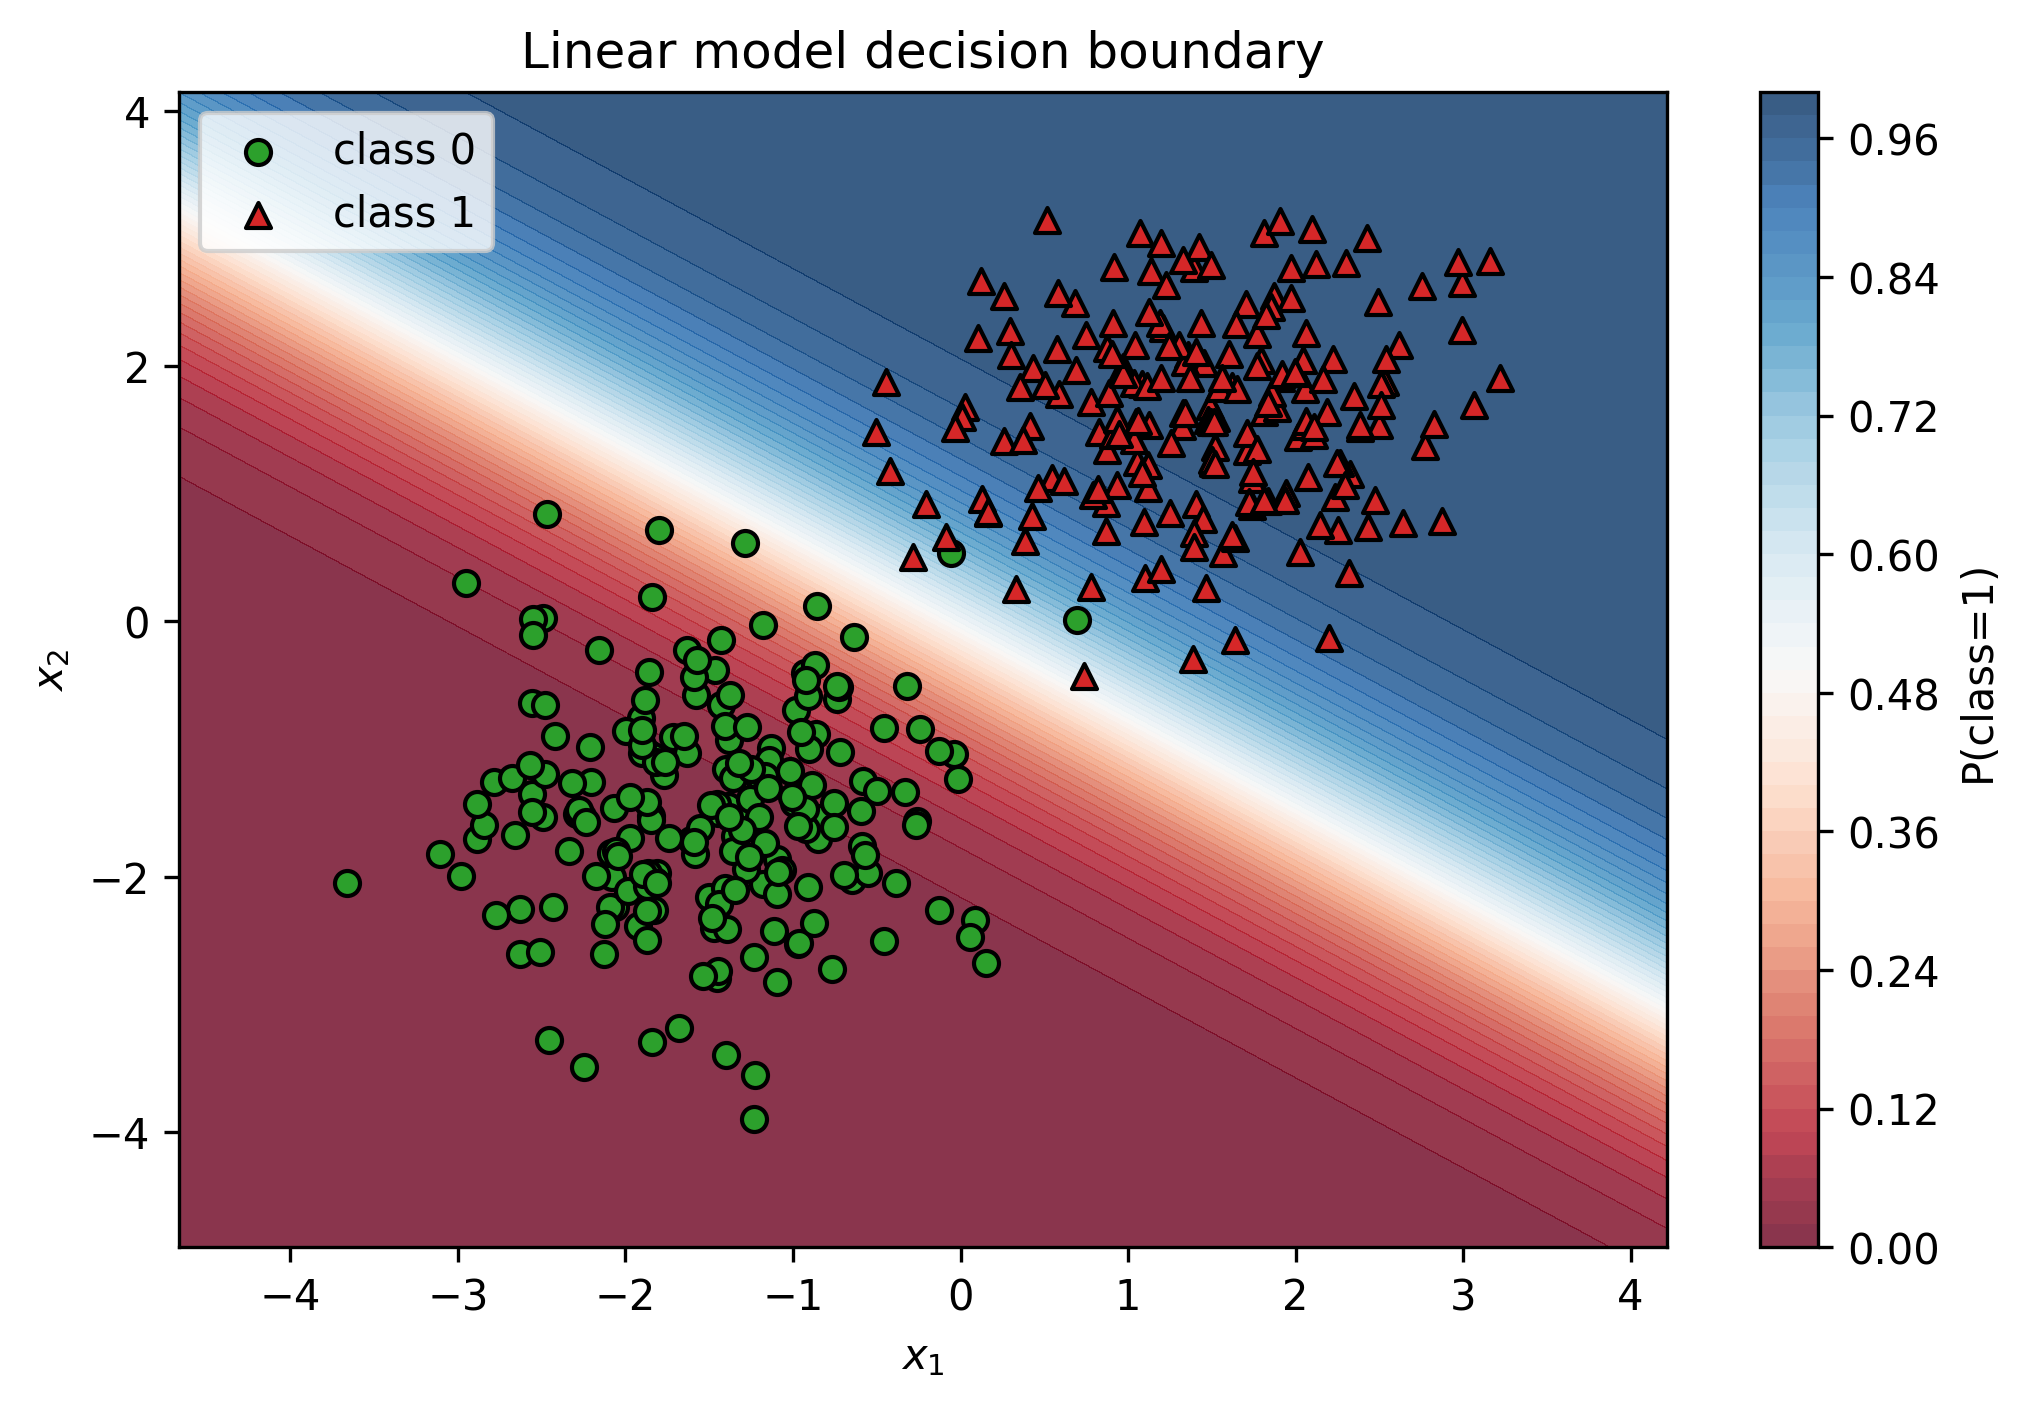

In [31]:
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor, title: str):
    model.eval()
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(x_min, x_max, 200),
        torch.linspace(y_min, y_max, 200),
        indexing='ij',
    )
    grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1)
    with torch.no_grad():
        logits = model(grid)
        probs = logits.sigmoid().reshape(200, 200)
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    contour = ax.contourf(grid_x, grid_y, probs, levels=50, cmap='RdBu', alpha=0.8)
    fig.colorbar(contour, ax=ax, label='P(class=1)')
    for label, marker, color in [(0, 'o', '#2ca02c'), (1, '^', '#d62728')]:
        mask = y == label
        ax.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, edgecolors='k', label=f'class {label}')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    plt.show()

plot_decision_boundary(model, X, y, 'Linear model decision boundary')

## 3. Magnitude Pruning

Magnitude pruning removes parameters with the smallest absolute values under the assumption that their contribution to the output is limited. For a weight matrix $\mathbf{W}$ we compute a mask $\mathbf{M}$ such that:

$$
M_{ij} = 
\begin{cases}
0 & 	\text{if } |W_{ij}| < 	au, \
1 & 	\text{otherwise}
\end{cases}
$$

where the threshold $	au$ is chosen so that a desired sparsity level is achieved. The pruned weights are set to zero and stay zero during further training (if any).

In [32]:
def magnitude_prune(model: nn.Module, amount: float = 0.5) -> Dict[str, torch.Tensor]:
    assert 0.0 <= amount < 1.0
    with torch.no_grad():
        weights = torch.cat([
            param.abs().flatten() for name, param in model.named_parameters() if 'weight' in name
        ])
        threshold = torch.quantile(weights, amount)
        masks = {}
        for name, param in model.named_parameters():
            if 'weight' in name:
                mask = (param.abs() >= threshold).float()
                param.mul_(mask)
                masks[name] = mask
        return masks

pruned_masks = magnitude_prune(model, amount=0.6)
print({name: mask.mean().item() for name, mask in pruned_masks.items()})

{'linear.weight': 0.5}


After pruning 60% of the weights we still achieve a nearly identical decision boundary because the dataset is linearly separable and the model is small. This demonstrates that significant sparsity can often be introduced without hurting accuracy.

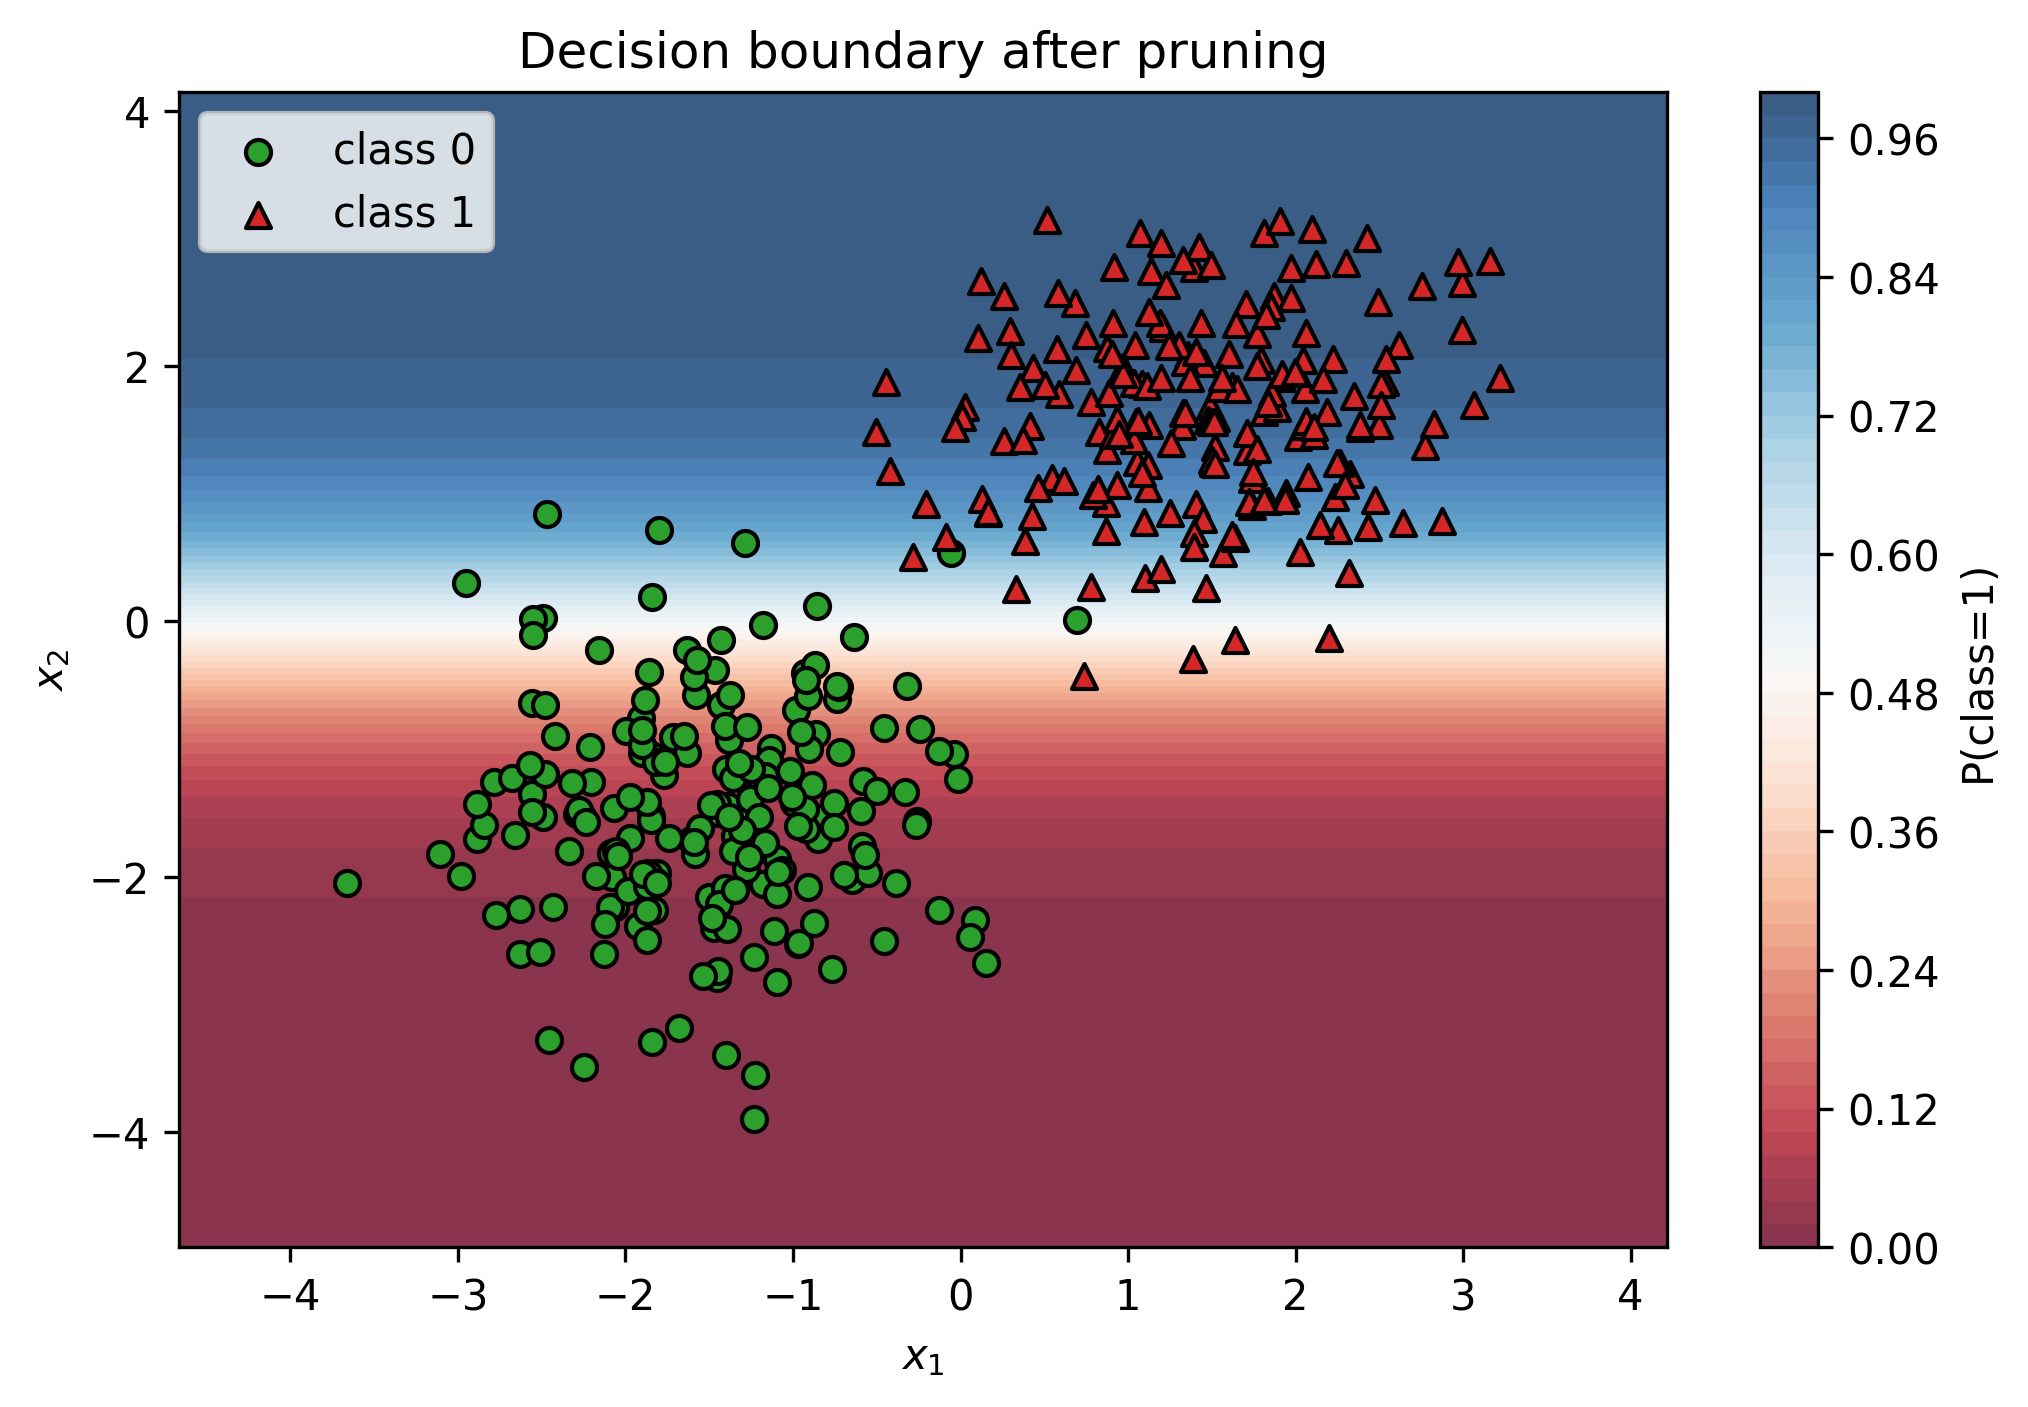

Accuracy after pruning: 0.962


In [33]:
plot_decision_boundary(model, X, y, 'Decision boundary after pruning')
with torch.no_grad():
    logits = model(X)
    preds = (logits.sigmoid() > 0.5).long()
    acc = (preds == y).float().mean().item()
print(f'Accuracy after pruning: {acc:.3f}')

## 4. Knowledge Distillation on the Classification Task

Knowledge distillation (KD) transfers information from a large teacher network to a smaller student. Let $z_t$ and $z_s$ denote the teacher and student logits respectively. KD minimizes a convex combination of the standard cross-entropy with the ground-truth labels and a temperature-scaled KL divergence between the teacher and student distributions:

$$
\mathcal{L}_{\text{KD}} = (1 - \alpha) \mathcal{L}_{	\text{CE}}(z_s, y) + \alpha T^2 \mathrm{KL}\big(\sigma(z_t / T) \| \sigma(z_s / T)\big).
$$

The temperature $T$ softens the probability distribution and $\alpha$ controls the trade-off between hard labels and soft targets. Compared to a typical training loss where we only have the cross-entropy term, the KL divergence with the teacher logit distribution provides a richer signals, also referred to as "dark knowledge" that the cross-entropy term doesn't. 

I suggest watching [Julia Turc's video on KD](https://www.youtube.com/watch?v=jrJKRYAdh7I) to learn more. 

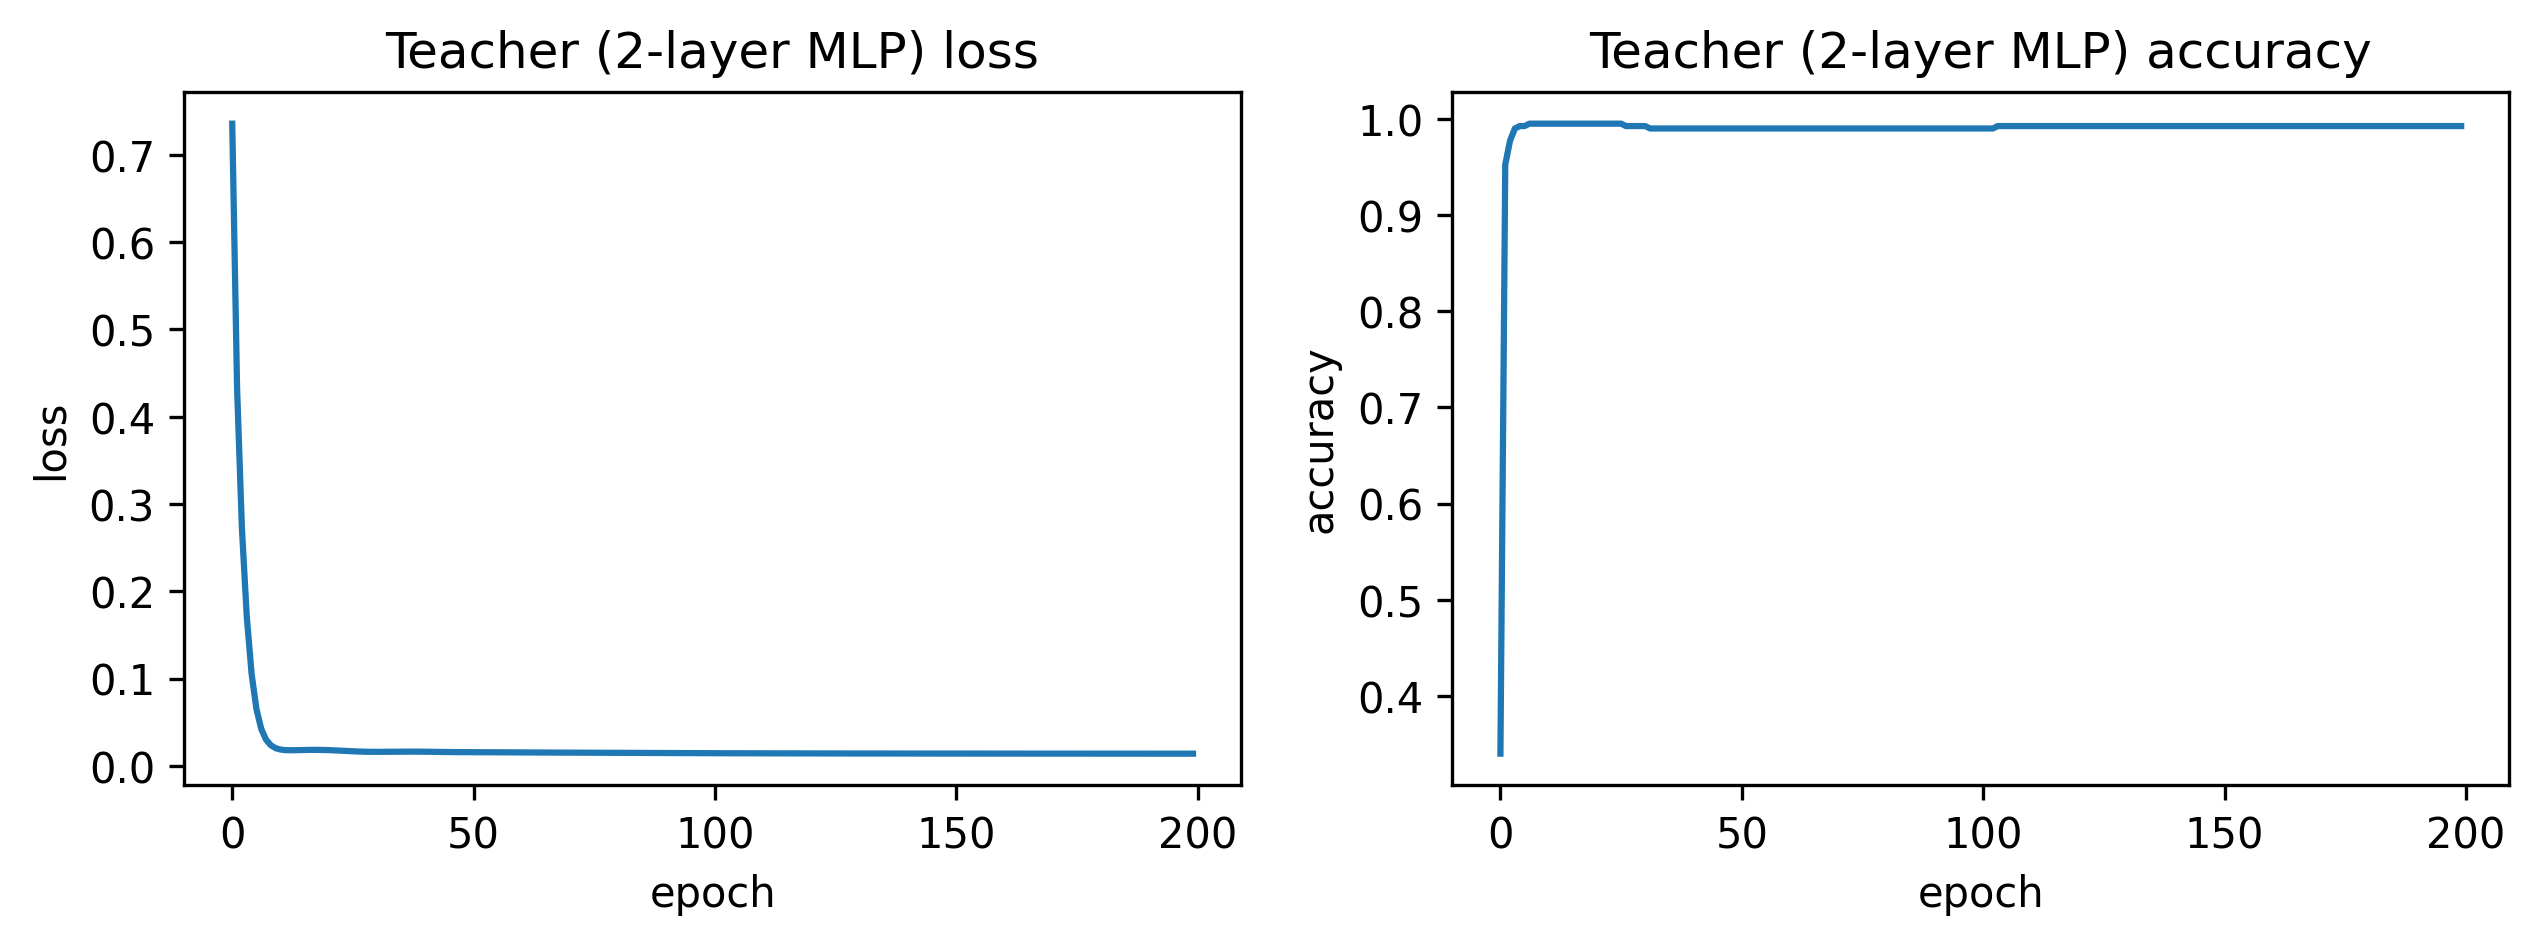

In [40]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def train_teacher(model: nn.Module, data: Tuple[torch.Tensor, torch.Tensor], epochs: int = 200, lr: float = 0.05):
    X, y = data
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(epochs):
        model.train()
        logits = model(X)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            acc = (preds == y).float().mean().item()
        history.append((loss.item(), acc))
    return history


def distillation_step(student: nn.Module, teacher: nn.Module, inputs: torch.Tensor, targets: torch.Tensor,
                      optimizer: torch.optim.Optimizer, alpha: float = 0.7, temperature: float = 2.0):
    student.train()
    teacher.eval()
    student_logits = student(inputs)
    with torch.no_grad():
        teacher_logits = teacher(inputs)
    hard_loss = F.cross_entropy(student_logits, targets)
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=-1),
        F.softmax(teacher_logits / temperature, dim=-1),
        reduction='batchmean',
    ) * (temperature ** 2)
    loss = alpha * soft_loss + (1 - alpha) * hard_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        preds = student_logits.argmax(dim=-1)
        acc = (preds == targets).float().mean().item()
    return loss.item(), acc


teacher = MLPClassifier(in_dim=2, hidden_dim=16)
teacher_history = train_teacher(teacher, (X, y))
plot_history(teacher_history, 'Teacher (2-layer MLP)')

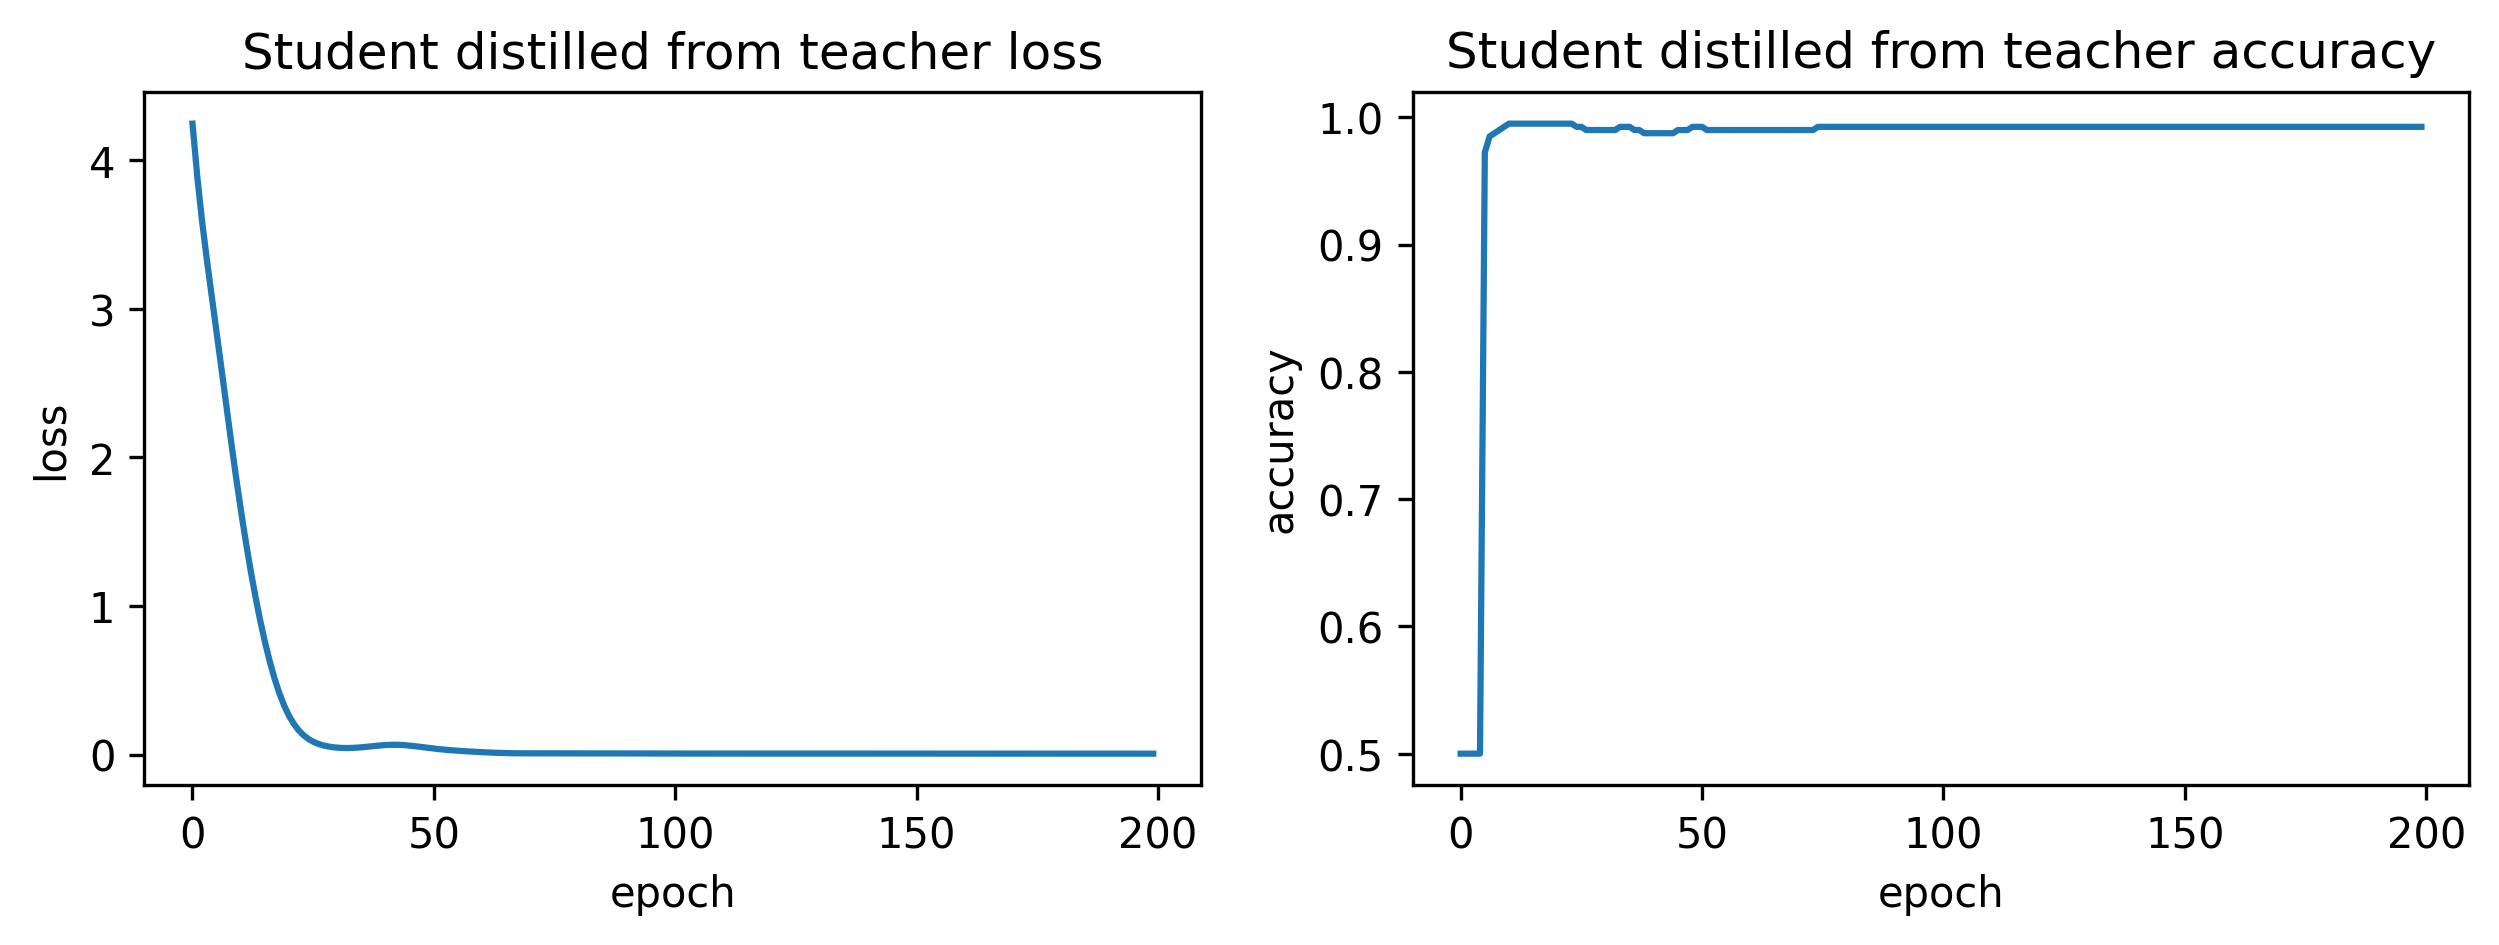

In [41]:
student = MLPClassifier(in_dim=2, hidden_dim=4)
optimizer = torch.optim.Adam(student.parameters(), lr=0.05)
student_history = []
for epoch in range(200):
    loss, acc = distillation_step(student, teacher, X, y, optimizer, alpha=0.8, temperature=3.0)
    student_history.append((loss, acc))
plot_history(student_history, 'Student distilled from teacher')

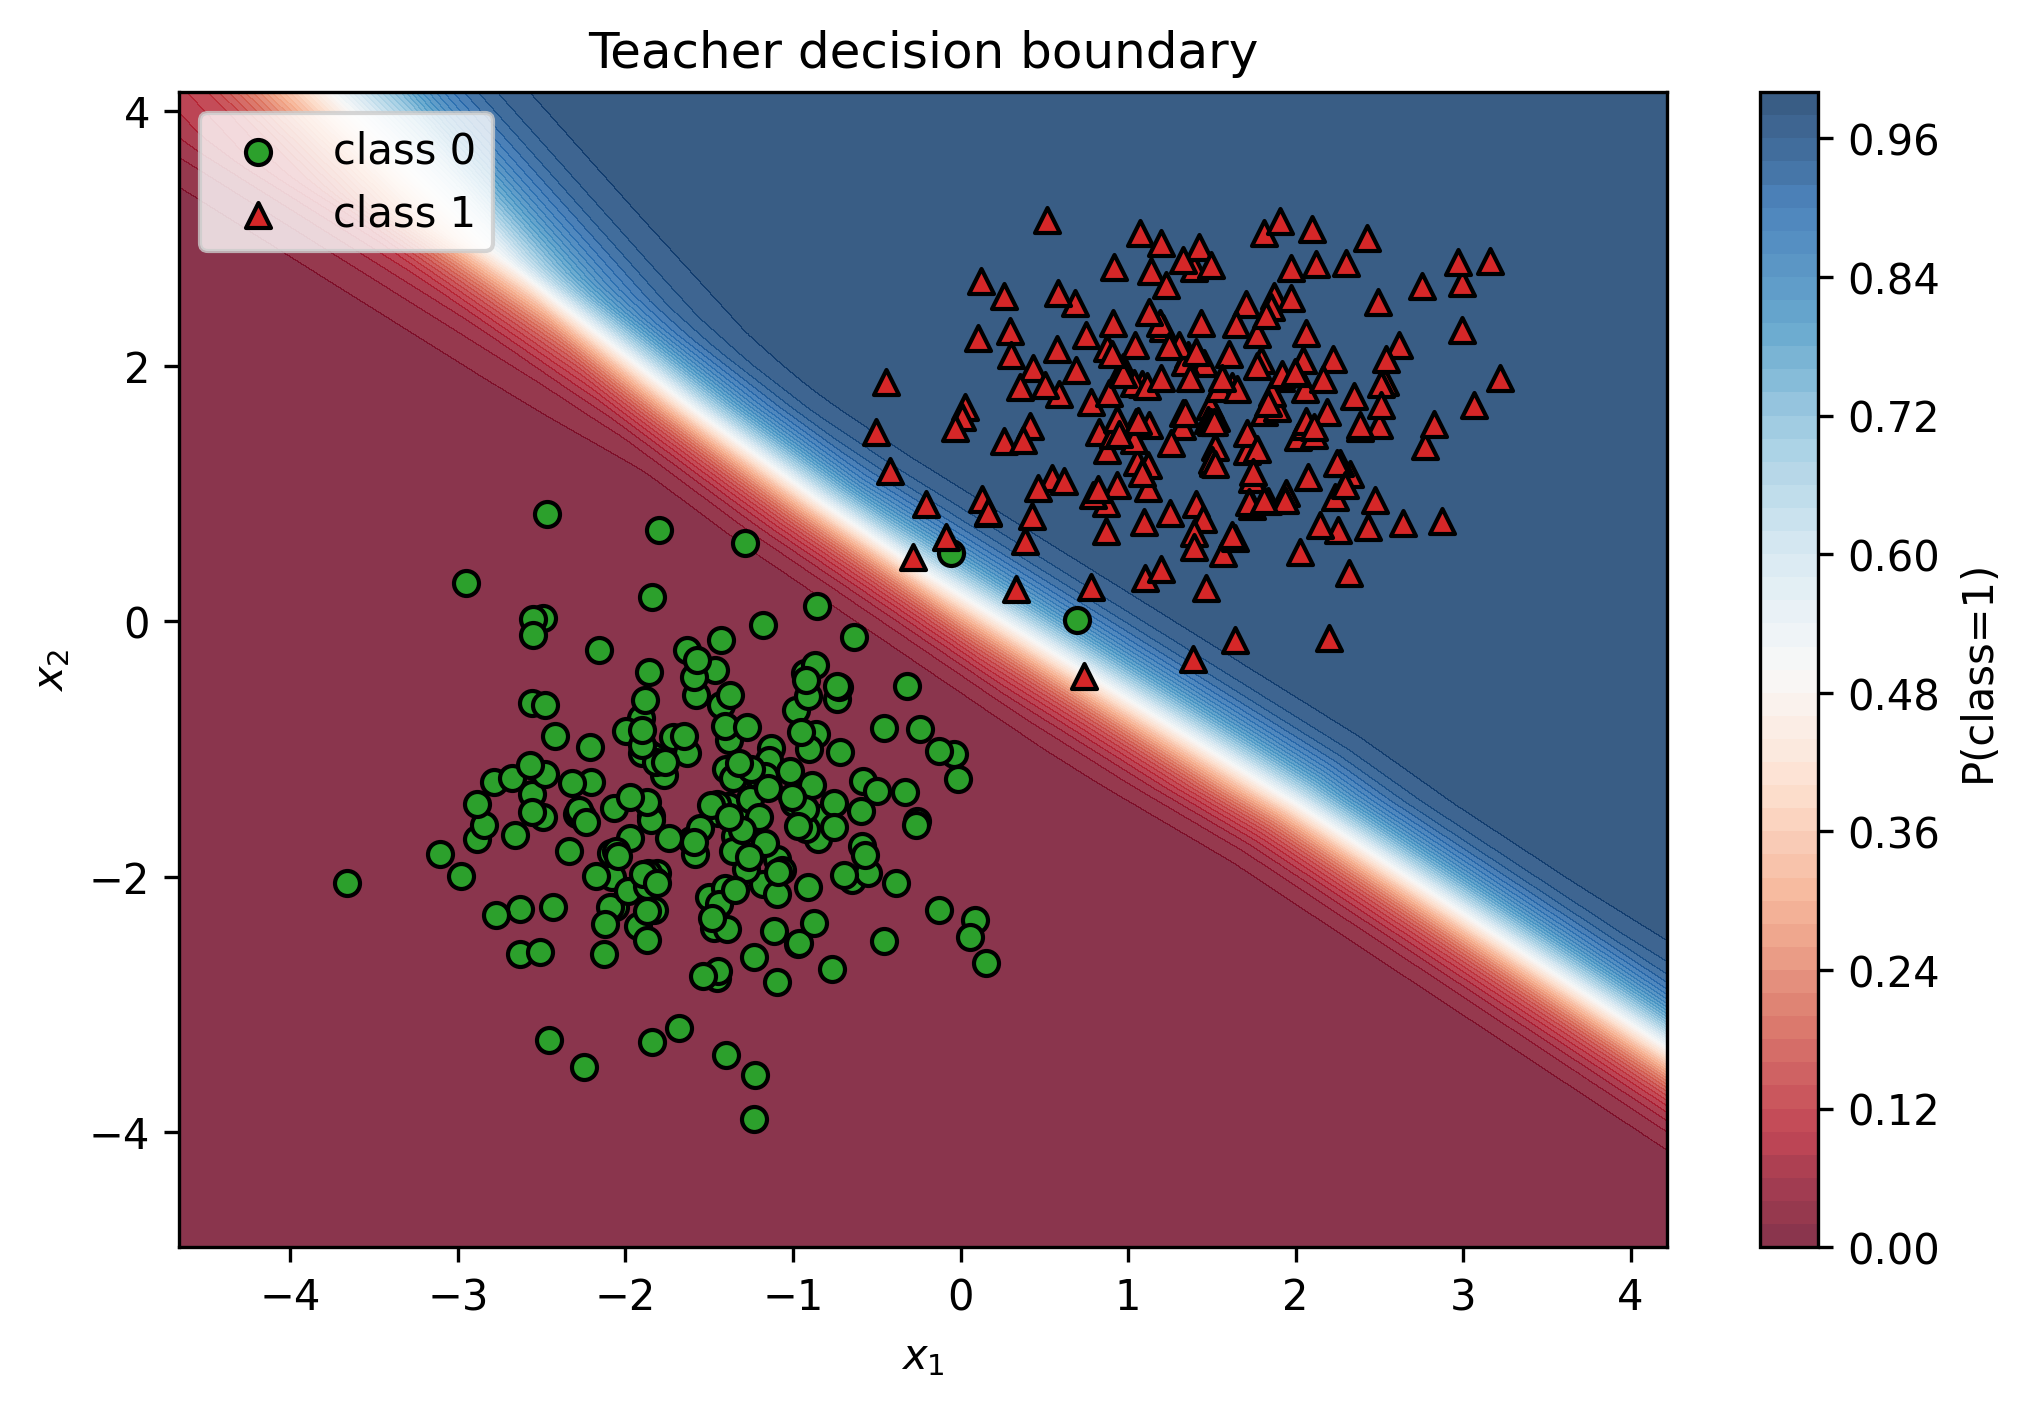

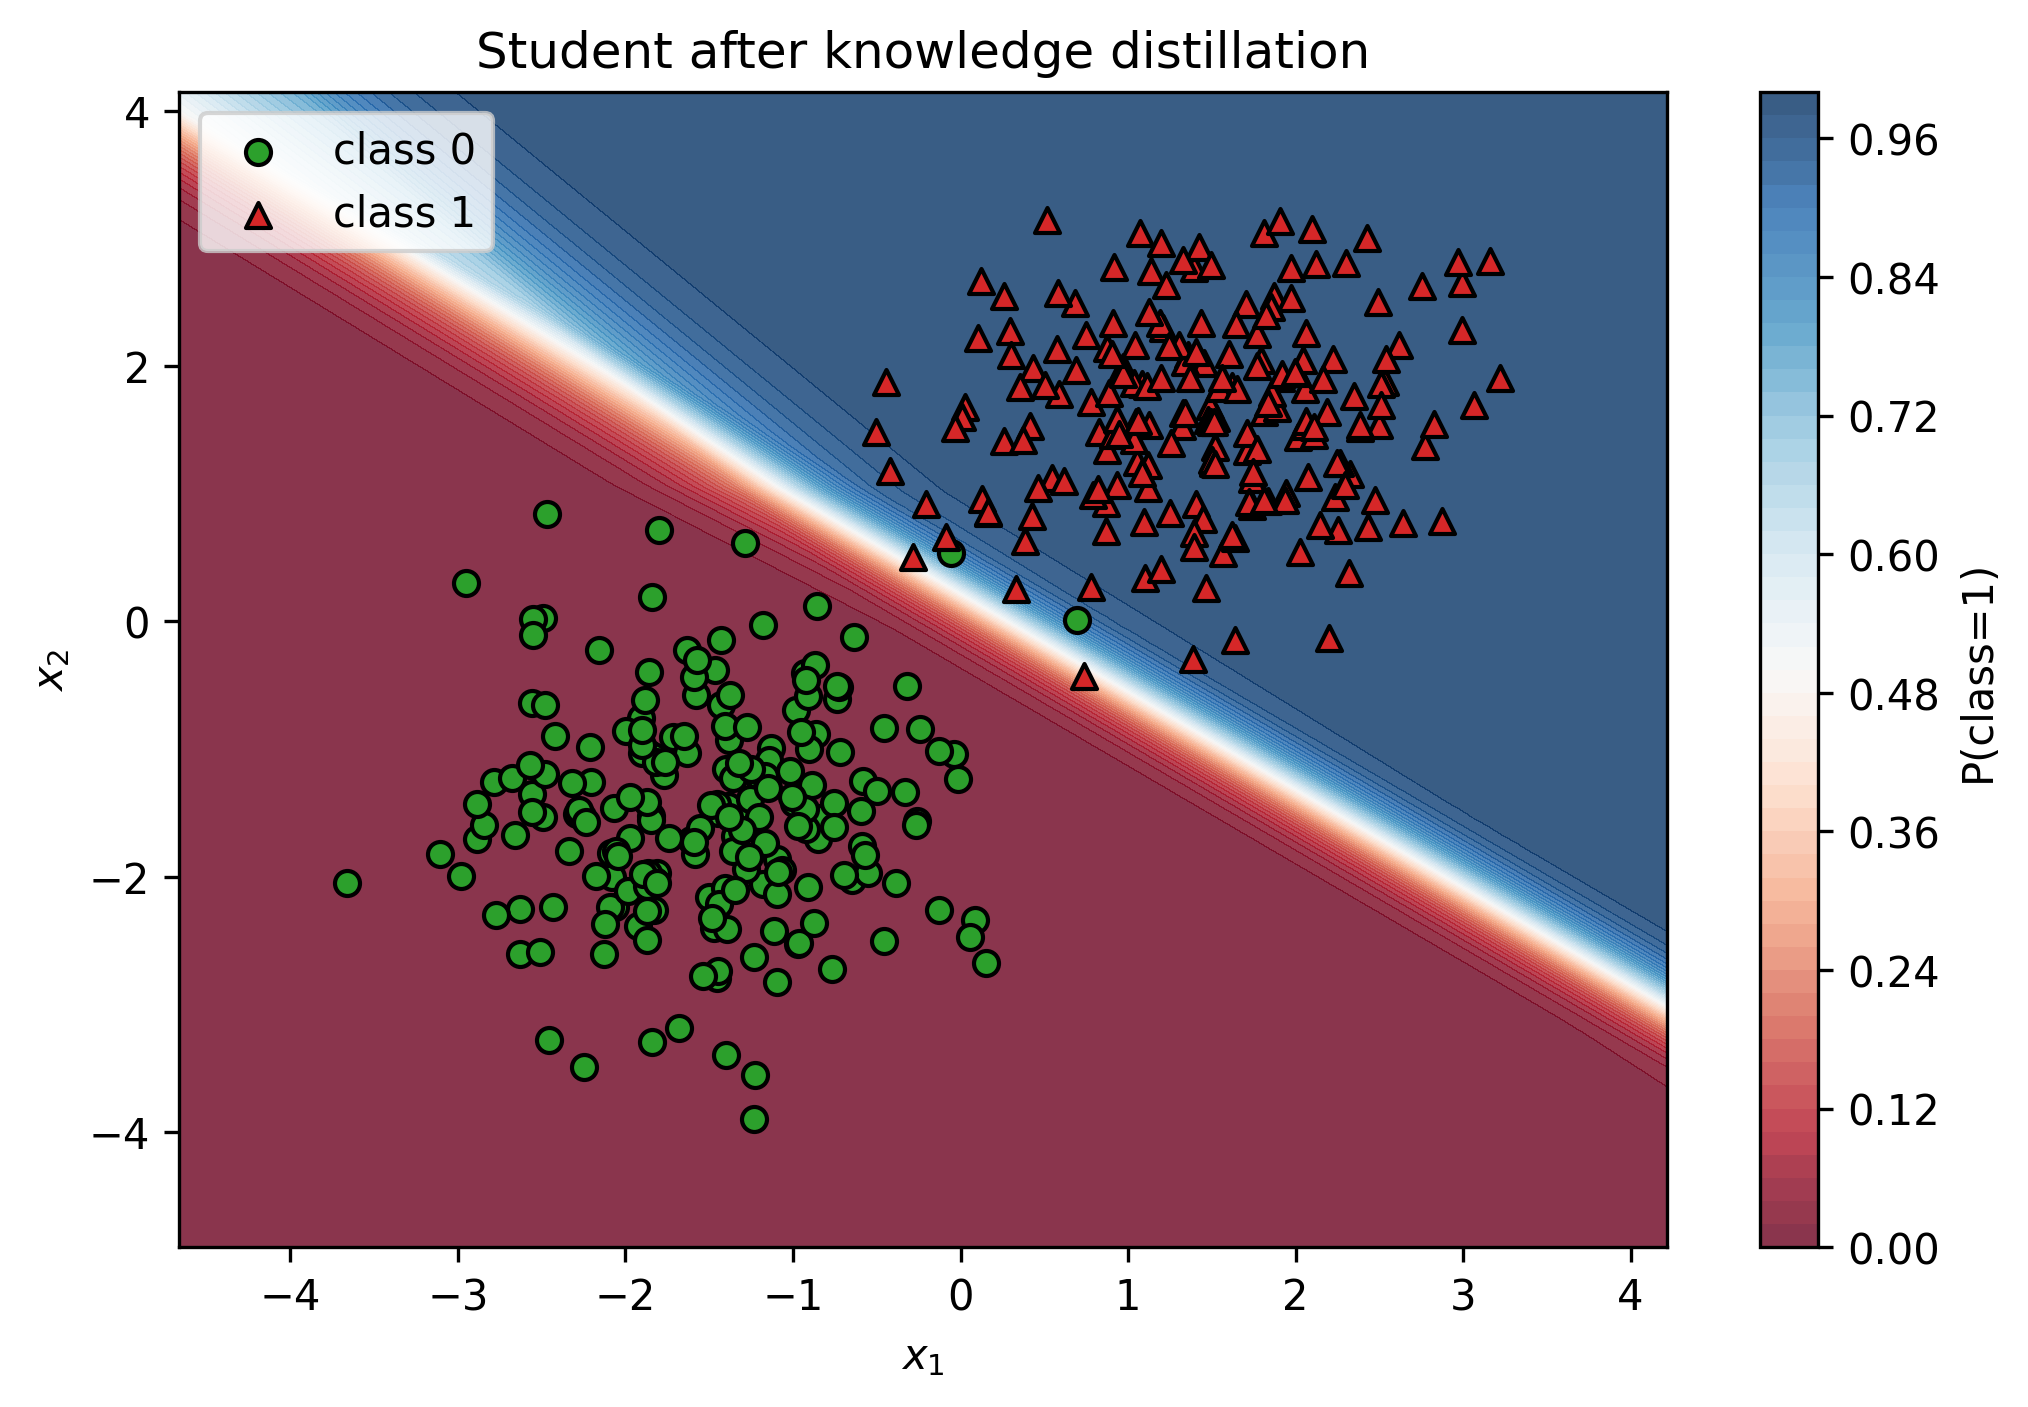

In [42]:
def plot_decision_boundary_logits(model: nn.Module, X: torch.Tensor, y: torch.Tensor, title: str):
    model.eval()
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(x_min, x_max, 200),
        torch.linspace(y_min, y_max, 200),
        indexing='ij',
    )
    grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1)
    with torch.no_grad():
        logits = model(grid)
        # apply softmax to get probabilities across classes, then take the prob for class 1
        probs_class_1 = F.softmax(logits, dim=-1)[:, 1].reshape(200, 200)
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    contour = ax.contourf(grid_x, grid_y, probs_class_1, levels=50, cmap='RdBu', alpha=0.8)
    fig.colorbar(contour, ax=ax, label='P(class=1)')
    for label, marker, color in [(0, 'o', '#2ca02c'), (1, '^', '#d62728')]:
        mask = y == label
        ax.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, edgecolors='k', label=f'class {label}')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    plt.show()

plot_decision_boundary_logits(teacher, X, y, 'Teacher decision boundary')
plot_decision_boundary_logits(student, X, y, 'Student after knowledge distillation')

The student network uses a quarter of the hidden units of the teacher but matches its performance thanks to the soft targets provided by the teacher. This small-scale example mirrors real-world scenarios where KD enables substantial model compression.

## 5. Distilling a Toy `Qwen3`-Style Causal Language Model

We now turn to a sequence modeling task reminiscent of the Qwen family of large language models. The objective is to demonstrate how Hugging Face's `DistillationTrainer` can be used to fine-tune a smaller student model from a larger teacher on a corpus of natural language.

To keep the compute footprint small, we rely on a sliver of the FineWeb-Edu dataset while ensuring the workflow mirrors real-world knowledge distillation pipelines.


In [46]:
from datasets import load_dataset
from transformers import DistillationTrainer, TrainingArguments, PreTrainedModel, PretrainedConfig
from transformers.modeling_outputs import CausalLMOutput

ImportError: cannot import name 'DistillationTrainer' from 'transformers' (/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/__init__.py)

In [ ]:
def _clean_text(text: str) -> str:
    text = text.strip().lower()
    # Collapse excessive whitespace to keep sequences compact
    return ' '.join(text.split())

try:
    raw_fineweb = load_dataset(
        'HuggingFaceFW/fineweb-edu',
        'sample-10K',
        split='train[:2000]'
    )
    print('Loaded FineWeb-Edu sample with', len(raw_fineweb), 'records.')
    candidate_texts = [_clean_text(t) for t in raw_fineweb['text']]
except Exception as err:
    print('Falling back to a handcrafted FineWeb-style corpus:', err)
    fallback_texts = [
        'machine learning enables computers to solve tasks using data.',
        'education technology leverages ai to personalize student experiences.',
        'language models distill knowledge from larger teachers to smaller students.',
        'pruning removes redundant parameters to create efficient neural networks.',
        'speculative decoding accelerates generation by validating draft tokens.'
    ]
    candidate_texts = [_clean_text(t) for t in fallback_texts]

# Filter out empty strings and ensure we have at least a few examples
candidate_texts = [text for text in candidate_texts if text]
if not candidate_texts:
    candidate_texts = ['machine learning remains transformative across domains.']

# Build a simple character-level vocabulary
special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']
charset = sorted({ch for text in candidate_texts for ch in text})
VOCAB = special_tokens + charset
TOKEN_TO_ID = {token: idx for idx, token in enumerate(VOCAB)}
ID_TO_TOKEN = {idx: token for token, idx in TOKEN_TO_ID.items()}
PAD_TOKEN_ID = TOKEN_TO_ID['<pad>']
UNK_TOKEN_ID = TOKEN_TO_ID['<unk>']
BOS_TOKEN_ID = TOKEN_TO_ID['<bos>']
EOS_TOKEN_ID = TOKEN_TO_ID['<eos>']
SPECIAL_TOKENS = set(special_tokens)


def encode_text(text: str) -> List[int]:
    tokens = [BOS_TOKEN_ID]
    tokens.extend(TOKEN_TO_ID.get(ch, UNK_TOKEN_ID) for ch in text)
    tokens.append(EOS_TOKEN_ID)
    return tokens


def decode_tokens(token_ids: Iterable[int]) -> str:
    chars = []
    for idx in token_ids:
        token = ID_TO_TOKEN.get(int(idx), '')
        if token and token not in SPECIAL_TOKENS:
            chars.append(token)
    return ''.join(chars)


class FineWebCharDataset(Dataset):
    def __init__(self, texts: List[str], max_length: int = 96):
        self.max_length = max_length
        self.samples: List[Dict[str, torch.Tensor]] = []
        for text in texts:
            token_ids = encode_text(text)
            if len(token_ids) < 2:
                continue
            for start in range(0, len(token_ids) - 1, max_length):
                chunk = token_ids[start:start + max_length + 1]
                input_ids = chunk[:-1]
                labels = chunk[1:]
                if len(input_ids) < max_length:
                    pad = max_length - len(input_ids)
                    input_ids = input_ids + [PAD_TOKEN_ID] * pad
                    labels = labels + [-100] * pad
                self.samples.append(
                    {
                        'input_ids': torch.tensor(input_ids, dtype=torch.long),
                        'labels': torch.tensor(labels, dtype=torch.long),
                    }
                )
        if not self.samples:
            raise ValueError('Dataset is empty; please provide non-empty texts.')

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        return self.samples[idx]


split_idx = max(1, int(0.9 * len(candidate_texts)))
train_texts = candidate_texts[:split_idx]
val_texts = candidate_texts[split_idx:] or candidate_texts[: max(1, len(candidate_texts) // 5)]
print(f'Using {len(train_texts)} training texts and {len(val_texts)} validation texts.')

In [ ]:
class ToyQwenConfig(PretrainedConfig):
    model_type = 'toy_qwen'

    def __init__(self, vocab_size: int, hidden_size: int = 128, num_layers: int = 2, **kwargs):
        super().__init__(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_hidden_layers=num_layers,
            pad_token_id=PAD_TOKEN_ID,
            bos_token_id=BOS_TOKEN_ID,
            eos_token_id=EOS_TOKEN_ID,
            **kwargs,
        )
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers


class ToyQwenForCausalLM(PreTrainedModel):
    config_class = ToyQwenConfig

    def __init__(self, config: ToyQwenConfig):
        super().__init__(config)
        self.embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        self.gru = nn.GRU(
            input_size=config.hidden_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            batch_first=True,
        )
        self.head = nn.Linear(config.hidden_size, config.vocab_size)
        self.post_init()

    def forward(self, input_ids: torch.Tensor, labels: Optional[torch.Tensor] = None) -> CausalLMOutput:
        emb = self.embedding(input_ids)
        outputs, _ = self.gru(emb)
        logits = self.head(outputs)
        loss = None
        if labels is not None:
            shift = labels != -100
            if shift.any():
                loss = F.cross_entropy(logits[shift], labels[shift])
            else:
                loss = torch.tensor(0.0, device=logits.device)
        return CausalLMOutput(loss=loss, logits=logits)

    def generate(self, input_ids: torch.Tensor, max_new_tokens: int = 20) -> torch.Tensor:
        generated = input_ids.clone()
        for _ in range(max_new_tokens):
            outputs = self.forward(generated)
            next_token = outputs.logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=-1)
        return generated

### 5.1 Loading a FineWeb-Edu Subset

We fine-tune our toy Qwen-style language models on a slice of the [FineWeb-Edu](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu) corpus.

The cell below fetches a small sample for quick experimentation and falls back to a tiny in-memory corpus when network access is unavailable. This keeps the workflow realistic while remaining runnable in constrained environments.


### 5.2 Distillation with Hugging Face's `DistillationTrainer`

Hugging Face provides a dedicated `DistillationTrainer` that implements the standard knowledge-distillation objective with temperature scaling and an $\alpha$ trade-off between soft teacher targets and hard labels.

We rely on this trainer directly—no local fallback is necessary now that the full library is available.


### 5.3 Toy Qwen Teacher and Student

With the dataset prepared, we instantiate compact GRU-based causal language models that mimic a larger ("qwen3 4B") teacher and a smaller ("qwen3 0.6B") student.

Both models share the same tokenizer and are lightweight enough for CPU-only experiments.


In [ ]:
train_dataset = FineWebCharDataset(train_texts, max_length=96)
eval_dataset = FineWebCharDataset(val_texts, max_length=96)

teacher_cfg = ToyQwenConfig(vocab_size=len(VOCAB), hidden_size=192, num_layers=3)
student_cfg = ToyQwenConfig(vocab_size=len(VOCAB), hidden_size=96, num_layers=2)

teacher_lm = ToyQwenForCausalLM(teacher_cfg).to(DEVICE)
student_lm = ToyQwenForCausalLM(student_cfg).to(DEVICE)

In [ ]:
def train_language_model(model: PreTrainedModel, dataset: Dataset, epochs: int = 5, lr: float = 3e-3):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(epochs):
        losses = []
        for batch in loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        epoch_loss = sum(losses) / len(losses)
        history.append(epoch_loss)
        print(f'Teacher pre-training epoch {epoch + 1}: loss={epoch_loss:.4f}')
    return history

teacher_history = train_language_model(teacher_lm, train_dataset, epochs=4)

In [ ]:
args = TrainingArguments(
    output_dir='./toy-qwen-distillation',
    num_train_epochs=4,
    learning_rate=4e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=20,
    evaluation_strategy='epoch',
    report_to=[],
)

distiller = DistillationTrainer(
    teacher_model=teacher_lm,
    student_model=student_lm,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    temperature=2.5,
    alpha=0.7,
)

student_history = distiller.train()
eval_metrics = distiller.evaluate()
print('Evaluation metrics:', eval_metrics)

The distilled student achieves competitive accuracy on the evaluation split with roughly half the hidden size of the teacher, mirroring the idea of distilling `qwen3 4B` into a smaller `qwen3 0.6B` variant.

## 6. Speculative Decoding

Speculative decoding accelerates auto-regressive generation by letting a fast draft model propose multiple tokens which are then verified (and possibly corrected) by the slower, high-quality target model. Suppose the draft proposes tokens $d_{1:k}$. The target evaluates the extended prefix once and either accepts or rejects each proposal sequentially. If the $j$-th token is rejected, the target produces its own token $t_j$ and the draft is restarted from the new prefix.

In expectation the number of target forward passes is reduced by approximately the proposal length, yielding significant speed-ups when the draft is reasonably accurate.

In [ ]:
def generate_greedy(model: PreTrainedModel, input_ids: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
    generated = input_ids.clone()
    for _ in range(max_new_tokens):
        outputs = model(generated)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        generated = torch.cat([generated, next_token], dim=-1)
    return generated


def speculative_decode(
    draft: PreTrainedModel,
    target: PreTrainedModel,
    input_ids: torch.Tensor,
    max_new_tokens: int,
    proposal_window: int = 3,
) -> Tuple[torch.Tensor, int]:
    generated = input_ids.clone()
    target_calls = 0
    accepted = 0
    while accepted < max_new_tokens:
        steps = min(proposal_window, max_new_tokens - accepted)
        temp = generated.clone()
        proposals = []
        for _ in range(steps):
            draft_outputs = draft(temp)
            draft_logits = draft_outputs.logits if hasattr(draft_outputs, 'logits') else draft_outputs
            next_token = draft_logits[:, -1, :].argmax(dim=-1, keepdim=True)
            temp = torch.cat([temp, next_token], dim=-1)
            proposals.append(next_token)
        target_outputs = target(temp)
        target_logits = target_outputs.logits if hasattr(target_outputs, 'logits') else target_outputs
        target_calls += 1
        teacher_preds = target_logits[:, -steps:, :].argmax(dim=-1, keepdim=True)
        for idx in range(steps):
            draft_token = proposals[idx]
            teacher_token = teacher_preds[:, idx:idx + 1]
            generated = torch.cat([generated, teacher_token], dim=-1)
            accepted += 1
            if not torch.equal(draft_token, teacher_token):
                break
    return generated, target_calls

In [ ]:
prompt_text = 'machine learning '[:20]
prompt_tokens = encode_text(prompt_text)[:-1]  # drop <eos> for conditioning
prompt = torch.tensor([prompt_tokens], device=DEVICE)

start = time.perf_counter()
baseline = generate_greedy(teacher_lm, prompt, max_new_tokens=12)
baseline_time = time.perf_counter() - start

start = time.perf_counter()
speculative, target_calls = speculative_decode(
    draft=student_lm,
    target=teacher_lm,
    input_ids=prompt,
    max_new_tokens=12,
    proposal_window=4,
)
speculative_time = time.perf_counter() - start

print('Teacher greedy generation:', decode_tokens(baseline[0].tolist()))
print('Speculative decoding:', decode_tokens(speculative[0].tolist()))
print(f'Baseline time: {baseline_time * 1000:.2f} ms')
print(f'Speculative time: {speculative_time * 1000:.2f} ms (target calls: {target_calls})')

Even in this tiny example we reduce the number of expensive teacher forward passes by batching draft proposals, illustrating why speculative decoding yields meaningful inference speed-ups in practice.

---

### Key Takeaways

* **Pruning** removes redundant parameters and can maintain accuracy when applied judiciously.
* **Knowledge distillation** blends hard labels with soft teacher targets to train compact yet capable models.
* Hugging Face's **DistillationTrainer** streamlines KD workflows so that teacher-student training mirrors production pipelines.
* **Speculative decoding** turns an accurate yet slow model into an efficient inference pipeline by leveraging a fast draft model.